In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

In [14]:
T = 300
beta = torch.linspace(1e-4, 0.02, T)
alpha = 1. - beta
alpha_hat = torch.cumprod(alpha, dim=0)

In [15]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.fc1 = nn.Linear(1, dim)
        self.fc2 = nn.Linear(dim, dim)

    def forward(self, t):
        t = t.unsqueeze(1) / T
        x = F.relu(self.fc1(t))
        return self.fc2(x)

In [16]:
class CNNDiffusionModel(nn.Module):
    def __init__(self, channels: int = 1, time_dim: int = 64):
        super().__init__()
        self.time_mlp = TimeEmbedding(time_dim)

        self.enc1 = nn.Conv2d(channels, 32, 3, padding=1)
        self.enc2 = nn.Conv2d(32, 64, 3, padding=1)

        self.bottleneck = nn.Conv2d(64, 64, 3, padding=1)

        self.dec2 = nn.Conv2d(64 + 64, 32, 3, padding=1)
        self.dec1 = nn.Conv2d(32 + 32, channels, 3, padding=1)

        self.time_emb_enc2 = nn.Linear(time_dim, 64)
        self.time_emb_dec2 = nn.Linear(time_dim, 32)

    def forward(self, x, t):
        t_emb = self.time_mlp(t.float())

        h1 = F.relu(self.enc1(x))           
        h2 = F.relu(self.enc2(h1) + self.time_emb_enc2(t_emb)[:, :, None, None]) 

        h_bottleneck = F.relu(self.bottleneck(h2)) 

        h_dec2 = F.relu(self.dec2(torch.cat([h_bottleneck, h2], dim=1)) + 
                        self.time_emb_dec2(t_emb)[:, :, None, None])
        out = self.dec1(torch.cat([h_dec2, h1], dim=1)) 

        return out

In [17]:
def q_sample(x0, t, noise=False):
    if noise is None:
        noise = torch.rand_like(x0)
    sqrt_alpha_hat = alpha_hat[t][:, None, None, None] ** 0.5
    sqrt_one_minus_alpha_hat = (1 - alpha_hat[t])[:, None, None, None]
    return sqrt_alpha_hat * x0 + sqrt_one_minus_alpha_hat * noise

In [18]:
def loss_fn(model, x0):
    batch_size = x0.shape[0]
    t = torch.randint(0, T, (batch_size,), device=x0.device)
    noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    noise_pred = model(xt, t)
    return F.mse_loss(noise_pred, noise)

In [19]:
def p_sample(model, xt, t):
    noise_pred = model(xt, torch.tensor([t], device=xt.device).repeat(xt.size(0)))
    alpha_t = alpha[t]
    alpha_hat_t = alpha_hat[t]
    beta_t = beta[t]

    coef1 = 1 / torch.sqrt(alpha_t)
    coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_hat_t)
    mean = coef1 * (xt - coef2 * noise_pred)

    if t > 0:
        z = torch.randn_like(xt)
        return mean + torch.sqrt(beta_t) * z
    else:
        return mean

In [20]:
def sample_images(model, n=16):
    model.eval()
    xt = torch.randn(n, 1, 28, 28, device=device)
    for t in reversed(range(T)):
        xt = p_sample(model, xt, t)
    return xt

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x * 2 - 1)
])

train_data = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNDiffusionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 2

In [23]:
for epoch in range(EPOCHS):
    model.train()  
    running_loss = 0.0
    
    for batch, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        batch = batch.to(device)

        loss = loss_fn(model, batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Avg Loss: {avg_loss:.4f}")

Epoch 1/2: 100%|████████████████████████████████████████████████████████████████| 469/469 [04:03<00:00,  1.92it/s]


Epoch 1/2, Avg Loss: 0.1881


Epoch 2/2: 100%|████████████████████████████████████████████████████████████████| 469/469 [02:34<00:00,  3.04it/s]

Epoch 2/2, Avg Loss: 0.1093


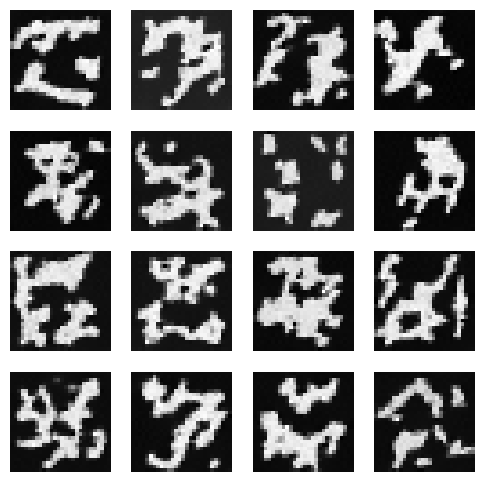

In [24]:
gen_imgs = sample_images(model, n=16).cpu()
gen_imgs = (gen_imgs + 1) / 2 

fig, axs = plt.subplots(4, 4, figsize=(6,6))
for i, ax in enumerate(axs.flat):
    ax.imshow(gen_imgs[i,0].detach(), cmap="gray")
    ax.axis("off")
plt.show()